In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
from pandas.tseries.holiday import USFederalHolidayCalendar

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

from yellowbrick.regressor import PredictionError, ResidualsPlot
from yellowbrick.model_selection import FeatureImportances
from yellowbrick.contrib.wrapper import regressor

from catboost import CatBoostRegressor

from scipy.optimize import minimize

## Sample data

In [2]:
len=1000
start, end = '1/1/2022', '2024-09-26'
date_indices = pd.date_range(start=start, periods=len, freq='d')

product_df = pd.DataFrame(np.random.random(size=(len, 4))*100, index=date_indices, columns=['price_p0','price_p1', 'price_p2', 'price_p3'])

## Feature Egineering

In [3]:
product_df

,price_p0,price_p1,price_p2,price_p3
2022-01-01,44.851077,91.353280,15.808595,17.097665
2022-01-02,21.850374,57.725474,57.604895,85.831561
2022-01-03,83.910197,5.880570,89.898453,39.630318
2022-01-04,41.209756,67.354724,75.929885,38.352187
2022-01-05,92.350472,60.807416,99.002257,48.651800
...,...,...,...,...
2024-09-22,87.554837,0.354055,51.003611,18.176320
2024-09-23,16.076802,61.007228,49.476299,91.645330
2024-09-24,37.466841,53.551722,30.254533,4.706025
2024-09-25,13.896940,58.452118,46.772790,9.791443


In [4]:
%%script false
df = pd.DataFrame()

Couldn't find program: 'false'


In [5]:
%%script false
#perform cyclic encoding
def encode(data, col, max_val):
    data[col + '_sin'] = np.sin(2 * np.pi * data[col]/max_val)
    data[col + '_cos'] = np.cos(2 * np.pi * data[col]/max_val)
    return data

Couldn't find program: 'false'


In [6]:
%%script false

# split date into cyclically encoded month (2x) year
df['date_month'] = df['date'].dt.month
customers = encode(df, 'date_month', 12)
customers['year'] = df['date'].dt.year

Couldn't find program: 'false'


In [7]:
%%script false
# map CommuteDistance
map = {'foo':0,'bar':1}
df['column_to_replace'].replace(map, inplace=True)

Couldn't find program: 'false'


In [8]:
%%script false
# replace all object types with categorical type
categorical = df.select_dtypes(include=['category']).columns
df[categorical] = df[categorical].apply(lambda x: x.cat.codes)

Couldn't find program: 'false'


In [9]:
%%script false
df['column_to_fill'].fillna(0, inplace=True)

Couldn't find program: 'false'


In [10]:
# might use German Holiday calendar instead
# https://github.com/dr-prodigy/python-holidays
holidays=USFederalHolidayCalendar()
holidays = holidays.holidays(start=start, end=end)
print(holidays)

DatetimeIndex(['2022-01-17', '2022-02-21', '2022-05-30', '2022-07-04',
               '2022-09-05', '2022-10-10', '2022-11-11', '2022-11-24',
               '2022-12-26', '2023-01-02', '2023-01-16', '2023-02-20',
               '2023-05-29', '2023-07-04', '2023-09-04', '2023-10-09',
               '2023-11-10', '2023-11-23', '2023-12-25', '2024-01-01',
               '2024-01-15', '2024-02-19', '2024-05-27', '2024-07-04',
               '2024-09-02'],
              dtype='datetime64[ns]', freq=None)


In [11]:
# weekday starts at 0 -> e. g. Monday = 0, Tuesday = 1
product_df['is_holiday'] = product_df.index.isin(holidays)
product_df['is_weekday'] = product_df.index.weekday <= 4
product_df['is_weekend'] = product_df.index.weekday > 4
product_df.head(10)

,price_p0,price_p1,price_p2,price_p3,is_holiday,is_weekday,is_weekend
2022-01-01,44.851077,91.353280,15.808595,17.097665,False,False,True
2022-01-02,21.850374,57.725474,57.604895,85.831561,False,False,True
2022-01-03,83.910197,5.880570,89.898453,39.630318,False,True,False
2022-01-04,41.209756,67.354724,75.929885,38.352187,False,True,False
2022-01-05,92.350472,60.807416,99.002257,48.651800,False,True,False
2022-01-06,87.808220,22.022812,38.894830,49.920275,False,True,False
2022-01-07,40.683617,4.567617,28.994387,73.121491,False,True,False
2022-01-08,80.315370,74.010999,80.934992,94.076763,False,False,True
2022-01-09,66.602364,40.531539,25.085837,42.351225,False,False,True
2022-01-10,35.754714,8.395197,78.874691,23.641909,False,True,False


In [12]:
# add some artifical demand -> higher prices, smaller demand with random factor
product_df['demand_p0'] = 100 - 1 * product_df['price_p0'] * (1 - 0.1 * np.random.random(size=(len)))
product_df['demand_p1'] = 100 - 1 * product_df['price_p1'] * (1 - 0.3 * np.random.random(size=(len)))

In [13]:
product_df

,price_p0,price_p1,price_p2,price_p3,is_holiday,is_weekday,is_weekend,demand_p0,demand_p1
2022-01-01,44.851077,91.353280,15.808595,17.097665,False,False,True,57.918552,20.564675
2022-01-02,21.850374,57.725474,57.604895,85.831561,False,False,True,79.598475,55.596054
2022-01-03,83.910197,5.880570,89.898453,39.630318,False,True,False,24.169768,95.712651
2022-01-04,41.209756,67.354724,75.929885,38.352187,False,True,False,60.429258,36.682131
2022-01-05,92.350472,60.807416,99.002257,48.651800,False,True,False,10.941046,39.621067
...,...,...,...,...,...,...,...,...,...
2024-09-22,87.554837,0.354055,51.003611,18.176320,False,False,True,13.133171,99.743090
2024-09-23,16.076802,61.007228,49.476299,91.645330,False,True,False,84.990352,45.032833
2024-09-24,37.466841,53.551722,30.254533,4.706025,False,True,False,62.559872,50.560153
2024-09-25,13.896940,58.452118,46.772790,9.791443,False,True,False,86.999788,42.263056


Text(0.5, 1.0, 'Correlation between features')

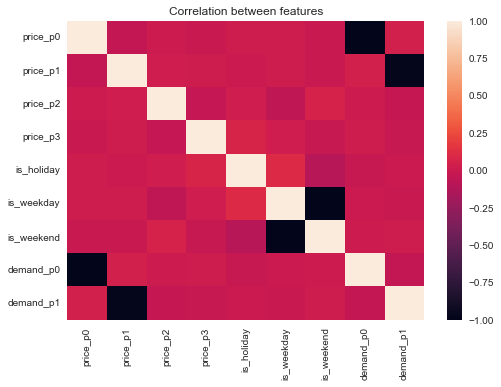

In [14]:
# Test correlation between features, plot should show high correlation between is weekend
# and is holiday. Due to linearity assumption there should be a positive correlation between
# price and demand.

corr = product_df.corr()
g = sns.heatmap(corr)
g.set_title("Correlation between features")

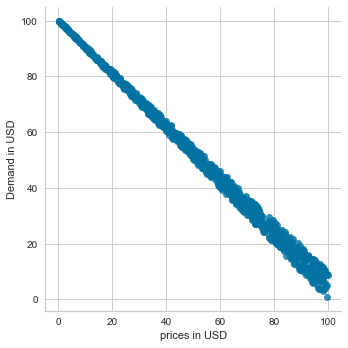

In [15]:
# plot price against demand
g = sns.lmplot(data=product_df, x='price_p0', y='demand_p0')
g.set_axis_labels("prices in USD", "Demand in USD")

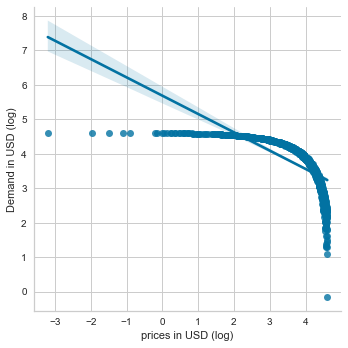

In [16]:
# test log transform, shouldn't be applied due to linear assumption in the model given above
product_df['log_price_p0'] = np.log(product_df['price_p0'])
product_df['log_demand_p0'] = np.log(product_df['demand_p0'])
g = sns.lmplot(data=product_df, x='log_price_p0', y='log_demand_p0')
g.set_axis_labels("prices in USD (log)", "Demand in USD (log)")

In [17]:
X_p0 = product_df[product_df.columns.difference(['demand_p0', 'log_demand_p0', 'log_price_p0'])]
y_p0 = product_df['demand_p0']

X_p1 = product_df[product_df.columns.difference(['demand_p1','log_demand_p0', 'log_price_p0'])]
y_p1 = product_df['demand_p1']

# do NOT shuffle to prevent leakage over time
X_train_p0, X_test_p0, y_train_p0, y_test_p0, X_train_p1, X_test_p1, y_train_p1, y_test_p1 = train_test_split(X_p0, y_p0, X_p1, y_p1, shuffle=False)

In [18]:
X_train_p0.head()

,demand_p1,is_holiday,is_weekday,is_weekend,price_p0,price_p1,price_p2,price_p3
2022-01-01,20.564675,False,False,True,44.851077,91.353280,15.808595,17.097665
2022-01-02,55.596054,False,False,True,21.850374,57.725474,57.604895,85.831561
2022-01-03,95.712651,False,True,False,83.910197,5.880570,89.898453,39.630318
2022-01-04,36.682131,False,True,False,41.209756,67.354724,75.929885,38.352187
2022-01-05,39.621067,False,True,False,92.350472,60.807416,99.002257,48.651800


In [19]:
X_train_p1.head()

,demand_p0,is_holiday,is_weekday,is_weekend,price_p0,price_p1,price_p2,price_p3
2022-01-01,57.918552,False,False,True,44.851077,91.353280,15.808595,17.097665
2022-01-02,79.598475,False,False,True,21.850374,57.725474,57.604895,85.831561
2022-01-03,24.169768,False,True,False,83.910197,5.880570,89.898453,39.630318
2022-01-04,60.429258,False,True,False,41.209756,67.354724,75.929885,38.352187
2022-01-05,10.941046,False,True,False,92.350472,60.807416,99.002257,48.651800


## Create simple baseline

In [20]:
print(X_train_p0.shape)
print(y_train_p0.shape)

(750, 8)
(750,)


In [21]:
# create simple predictor for product 0
lr_p0 = LinearRegression().fit(X_train_p0, y_train_p0)
y_pred = lr_p0.predict(X_test_p0)

In [22]:
r2 = r2_score(y_test_p0, y_pred)
mse = mean_squared_error(y_test_p0, y_pred)

print(f"R2:{r2}")
print(f"MSE:{mse}")

R2:0.9958309172189521
MSE:3.1471351659848468


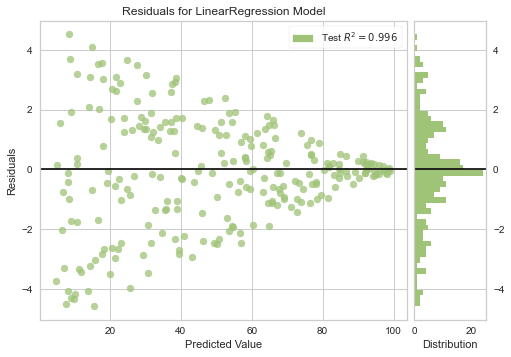

<AxesSubplot:title={'center':'Residuals for LinearRegression Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [23]:
# explained variance should be high
visualizer = ResidualsPlot(lr_p0, is_fitted=True)
visualizer.score(X_test_p0,y_test_p0)
visualizer.show()

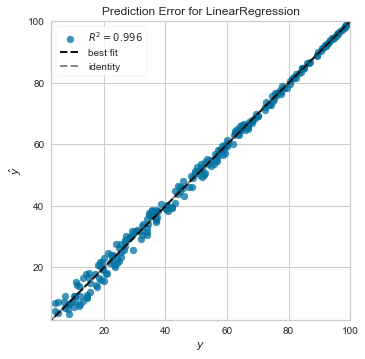

<AxesSubplot:title={'center':'Prediction Error for LinearRegression'}, xlabel='$y$', ylabel='$\\hat{y}$'>

In [24]:
visualizer = PredictionError(lr_p0, is_fitted=True)
visualizer.score(X_test_p0,y_test_p0)
visualizer.show()

In [25]:
# create simple predictor for product 1
lr_p1 = LinearRegression().fit(X_train_p1, y_train_p1)
y_pred = lr_p1.predict(X_test_p1)

## Create second simple baseline

In [26]:
%%script false
cat = CatBoostRegressor(task_type='GPU')
cat.fit(X_train_p1, y_train_p1)

y_pred = cat.predict(X_test_p1)

Couldn't find program: 'false'


In [27]:
%%script false
r2 = r2_score(y_test_p1, y_pred)
mse = mean_squared_error(y_test_p1, y_pred)

print(f"R2:{r2}")
print(f"MSE:{mse}")

Couldn't find program: 'false'


In [28]:
%%script false
# explained variance should be high
visualizer = ResidualsPlot(cat, is_fitted=True)
visualizer.score(X_test_p1,y_test_p1)
visualizer.show()

Couldn't find program: 'false'


In [29]:
%%script false
visualizer = PredictionError(cat, is_fitted=True)
visualizer.score(X_test_p1,y_test_p1)
visualizer.show()

Couldn't find program: 'false'


In [30]:
%%script false
# show feature importances of GBM
viz = FeatureImportances(regressor(cat), is_fitted=True, topn=len(X_train_p1.columns))
viz.fit(X_train_p1, y_train_p1)
viz.show()

Couldn't find program: 'false'


## Optimize product portfolio

In [31]:
%%script false
# implement BGFS
def neg_margin(model_p0, model_p1, X_p0, X_p1, cost_p0 = 50, cost_p1 = 30):

    demand_p0 = model_p0.predict(X_p0)
    demand_p1 = model_p1.predict(X_p1) 

    return - demand_p0 * (X_p0['price_p0']-cost_p0) - demand_p1 * (X_p1['price_p1']-cost_p1])

# risk budgeting approach optimisation object function
def obj_fun(x, p_cov, rb):
	return np.sum((x*np.dot(p_cov, x)/np.dot(x.transpose(), np.dot(p_cov, x))-rb)**2)

# add constraints, initial guesses etc. [...]
# minimize(obj_fun, w0, args=(p_cov, rb), method='L-BFGS-B', constraints=cons)
